# **Projet 5 - <span style="color:#1d479b">Segmentez les clients d'un site e-commerce</span>**
---

**<span style="color:#1d479b">Objectif de la mission:</span>**
* Fournir une **segmentation des clients** afin d'apporter des informations supplémentaires aux équipes pour leurs campagnes de communication.
* **Comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.
* Fournir une **description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale.
* Proposition de **contrat de maintenance basée sur une analyse de la stabilité** des segments au cours du temps..

## **0. Importation des librairies et des données**
---

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# ---
#scikit-learn
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#classe pour l'ACP
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
#Classes pour le clustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
path_customers = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P5_Segmentez_Des_Clients_Dun_Site_e_commerce/df_final.csv"
df_customers = pd.read_csv(path_customers, sep=",")
df = df_customers.copy()

### **0.1 - Définition de la charte graphique**

In [3]:
["#00317a","#1d479b","#FFF","#F1F1F1","#333","#000"]

['#00317a', '#1d479b', '#FFF', '#F1F1F1', '#333', '#000']

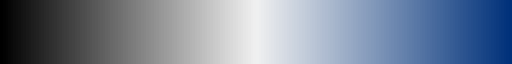

In [4]:
# Define the heatmap color
first_color = "#000"
under_color = "#F1F1F1"
over_color = "#00317a"
# Create a personal color map 
colors = [first_color,under_color, over_color]
n_bins = 200
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

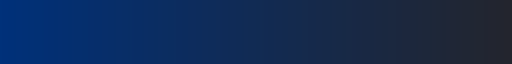

In [5]:
palette_b = sns.dark_palette("#00317a", reverse=True, as_cmap=True)
palette_b

In [6]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#00317a", n_colors=n_colors,as_cmap=False)
palette_map

[(0.13938124775110491, 0.14652229085327886, 0.17972974582003676),
 (0.12407664015490516, 0.15153314580610608, 0.2125283558138074),
 (0.1087720325587054, 0.15654400075893327, 0.2453269658075781),
 (0.09292083183406995, 0.1617338148172186, 0.27929695472969773),
 (0.0776162242378702, 0.1667446697700458, 0.3120955647234684),
 (0.06176502351323472, 0.17193448382833112, 0.346065553645588),
 (0.04646041591703498, 0.1769453387811583, 0.37886416363935865),
 (0.030609215192399508, 0.18213515283944365, 0.41283415256147826),
 (0.015304607596199768, 0.18714600779227084, 0.4456327625552489),
 (0.0, 0.19215686274509805, 0.47843137254901963)]

### **0.2 - Normalisation de l'affichage des graphiques**

In [7]:
# Defines display options for rows and columns
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#000'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

In [9]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16, 
                  "axes.labelsize":10, 
                  "xtick.labelsize":8, 
                  "ytick.labelsize":8, 
                  "xtick.color":"#333", 
                  "ytick.color":"#333", 
                  "axes.titlecolor":"#000", 
                  "axes.labelcolor":"#000"
                  })

## **1. Traitement des données**
***

In [10]:
df.sample(1)

,customer_unique_id,review_score,payment_installments,payment_sequential,average_price,average_freight_value,average_product_weight_g,product_volume_cm3,nb_product_per_order,days_since_last_order,days_between_purchase_delivery,nb_orders_per_customer
68524,bce72558f421c2a875e69c282ef2ec51,5.0,1.0,1.0,29.45,10.96,600.0,13000.0,2.0,2444.0,5.0,1.0


La colonne `customer_unique_id` est supprimée pour le clustering.

In [11]:
df = df.drop(columns="customer_unique_id")

Les données sont normalisées à 2 chiffres après la virgule.

In [12]:
df = df.round(2)

Et les types des données est vérifié avant le clustering.

In [13]:
df.dtypes

review_score                      float64
payment_installments              float64
payment_sequential                float64
average_price                     float64
average_freight_value             float64
average_product_weight_g          float64
product_volume_cm3                float64
nb_product_per_order              float64
days_since_last_order             float64
days_between_purchase_delivery    float64
nb_orders_per_customer            float64
dtype: object

## **2. Clustering**
***

Le clustering est testé dans un premier temps à partir des données minimales d'une segmentation RFM (Récence,Fréquence,Montant) + `review_score`.

In [14]:
df

,review_score,payment_installments,payment_sequential,average_price,average_freight_value,average_product_weight_g,product_volume_cm3,nb_product_per_order,days_since_last_order,days_between_purchase_delivery,nb_orders_per_customer
0,5.0,8.0,1.0,129.90,12.00,1500.0,7616.0,1.0,2038.0,6.0,1.0
1,4.0,1.0,1.0,18.90,8.29,375.0,5148.0,1.0,2041.0,3.0,1.0
2,3.0,8.0,1.0,69.00,17.22,1500.0,43750.0,1.0,2463.0,25.0,1.0
3,4.0,4.0,1.0,25.99,17.63,150.0,1045.0,1.0,2247.0,20.0,1.0
4,5.0,6.0,1.0,180.00,16.89,6050.0,528.0,1.0,2214.0,13.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
92734,5.0,10.0,1.0,785.00,248.71,30000.0,251625.0,2.0,2373.0,27.0,1.0
92735,4.0,1.0,1.0,64.89,19.69,1720.0,32076.0,1.0,2188.0,30.0,1.0
92736,5.0,1.0,1.0,89.90,22.56,600.0,3315.0,1.0,2494.0,14.0,1.0
92737,5.0,5.0,1.0,115.00,18.69,444.0,4480.0,1.0,2045.0,11.0,1.0


In [15]:
df_cluster = df[["review_score","payment_installments","average_price","days_since_last_order","nb_orders_per_customer"]]

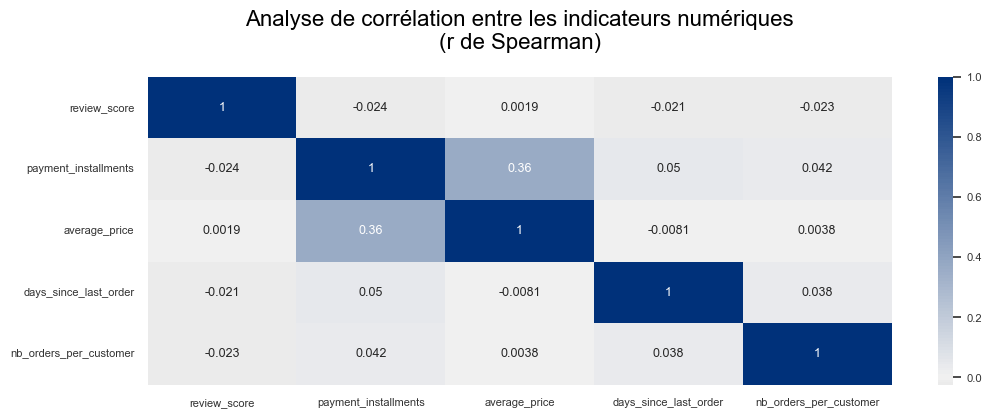

In [16]:
# Digital DF for correlation analysis
#df_corr = df.select_dtypes(include=['float64', 'int64']).drop(columns=["Latitude","Longitude"])

# Analysis of correlations between variables
plt.figure(figsize=(12,4))
sns.heatmap(df_cluster.corr(method="spearman"), center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('Analyse de corrélation entre les indicateurs numériques\n(r de Spearman)')
plt.show()

Les données sont centrées et réduites (moyenne=0; Ecart-type=1).

In [17]:
#Instanciation
sc = StandardScaler()
#Transformation - Centrage-Réduction / Mise à l'échelle (moyenne=0; Ecart-type=1)
X = sc.fit_transform(df_cluster)
print(X)

[[ 0.661809    1.85626675  0.02240014 -0.83425463 -0.16178956]
 [-0.11921707 -0.72334207 -0.56476374 -0.81456055 -0.16178956]
 [-0.90024315  1.85626675 -0.29974653  1.95574076 -0.16178956]
 ...
 [ 0.661809   -0.72334207 -0.18919045  2.15924631 -0.16178956]
 [ 0.661809    0.75072012 -0.05641735 -0.78830177 -0.16178956]
 [ 0.661809    0.38220457 -0.3632766   1.60781192 -0.16178956]]


### **2.1   K-Means**

#### **2.1-1   Mesure de Qualité**

##### **Indice de Davies-Bouldin**

In [18]:
score_bouldin = []

for n_clust in range(2,10):
 # Clustering par K-means avec initialisation K-means++
 km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
 km.fit(X)
 # Récupération des clusters attribués à chaque individu
 clusters = km.labels_
 # Application de la mesure Davies Bouldin
 score_bouldin.append(davies_bouldin_score(X, km.labels_))

print(score_bouldin)

[1.6178816002385326, 1.5606829545171814, 1.2150422738629587, 1.0023956114438923, 1.1506373945328998, 1.2136126470626736, 1.059085809236849, 1.0708859738504823]


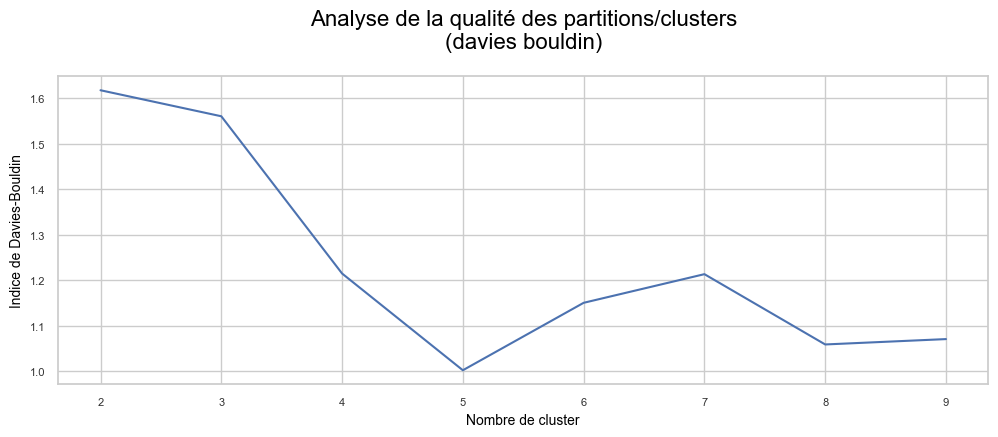

In [19]:
#Analyse des regroupements de clusters
plt.figure(figsize=(12,4))
plt.plot(range(2,10), score_bouldin)
plt.title('Analyse de la qualité des partitions/clusters\n(davies bouldin)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

In [20]:
"""score_silhouette = []

for n_clust in range(2,10):
 # Clustering par K-means avec initialisation K-means++
 km = KMeans(n_clusters=n_clust, init='k-means++', n_init='auto', random_state=42, verbose=1)
 km.fit(X)
 # Récupération des clusters attribués à chaque individu
 clusters = km.labels_
 # Application de la mesure Silhouette
 score_silhouette.append(silhouette_score(X, km.labels_))
 print("silhouette terminé")

print(score_silhouette)"""

Initialization complete
Iteration 0, inertia 611995.132146037.
Iteration 1, inertia 390879.4761597363.
Iteration 2, inertia 386667.3962593925.
Iteration 3, inertia 384296.8163681173.
Iteration 4, inertia 383392.267495854.
Iteration 5, inertia 383122.06903157965.
Iteration 6, inertia 383026.76156066754.
Iteration 7, inertia 382998.6865330975.
Iteration 8, inertia 382991.5541783025.
Converged at iteration 8: center shift 5.169148021431486e-05 within tolerance 9.999999999996021e-05.
silhouette terminé
Initialization complete
Iteration 0, inertia 467758.6580042049.
Iteration 1, inertia 334806.572148873.
Iteration 2, inertia 333470.97459861764.
Iteration 3, inertia 332818.5439647062.
Iteration 4, inertia 332307.3331093997.
Iteration 5, inertia 331816.6331985556.
Iteration 6, inertia 331425.93676890625.
Iteration 7, inertia 331164.14419359487.
Iteration 8, inertia 331013.71709814965.
Iteration 9, inertia 330913.96462654043.
Iteration 10, inertia 330857.27185048617.
Iteration 11, inertia 3308

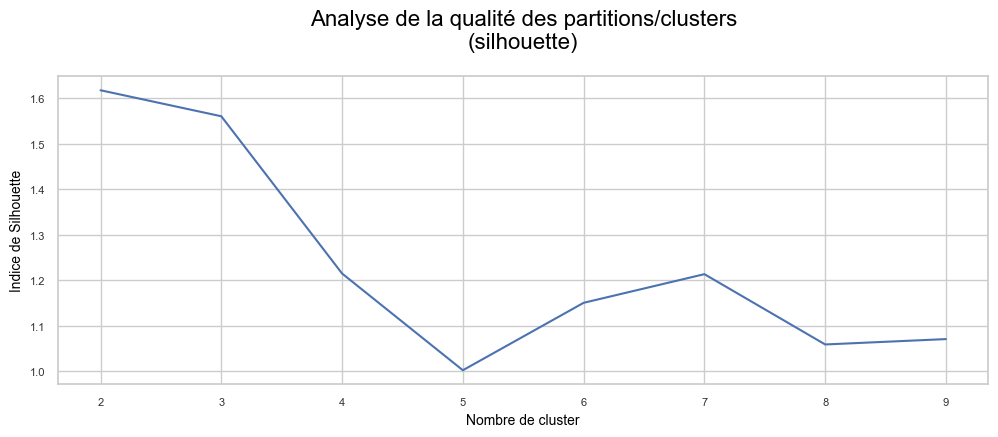

In [21]:
"""#Analyse des regroupements de clusters
plt.figure(figsize=(12,4))
plt.plot(range(2,10), score_bouldin)
plt.title('Analyse de la qualité des partitions/clusters\n(silhouette)')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Silhouette")
plt.show()"""

##### **4.1-2   Analyse des clusters**

In [22]:
#Instanciation du nombre de clusters
n_clust = 5
#Instanciation du clustering k-means
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
#Application du K-means sur le data set
km.fit(X)
#Récupération des clusters attribués à chaque individu
clusters = km.labels_

In [23]:
#Instanciation du df suite clustering
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
#Ajout de la colonne clusters + Remplissage avec le n° cluster correspondant
df_kmean['clusters'] = clusters
#print(df_kmean)

In [24]:
#Moyenne des composantes par clusters
centroide_kmean = df_kmean.groupby(by='clusters').mean()

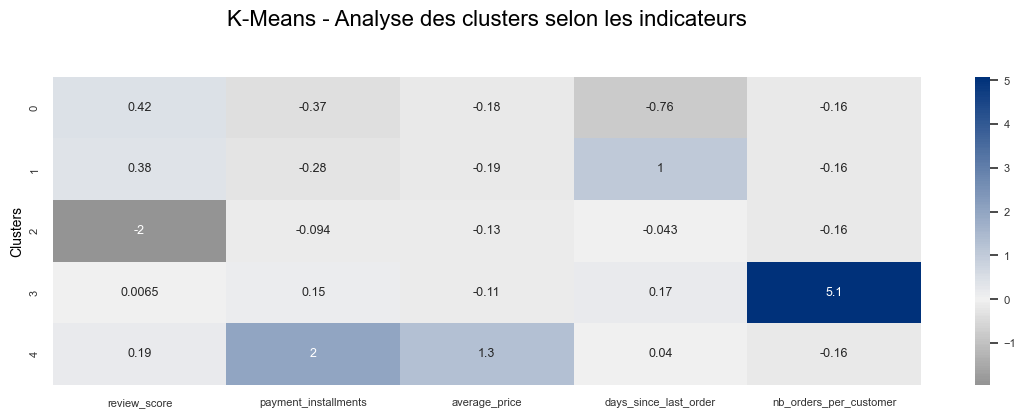

In [25]:
#Création du heatmap pour observer les différents clusters et composantes
plt.figure(figsize=(14,4))
sns.heatmap(centroide_kmean, center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('K-Means - Analyse des clusters selon les indicateurs\n')
plt.ylabel('Clusters')
plt.show()

Analyse des clusters

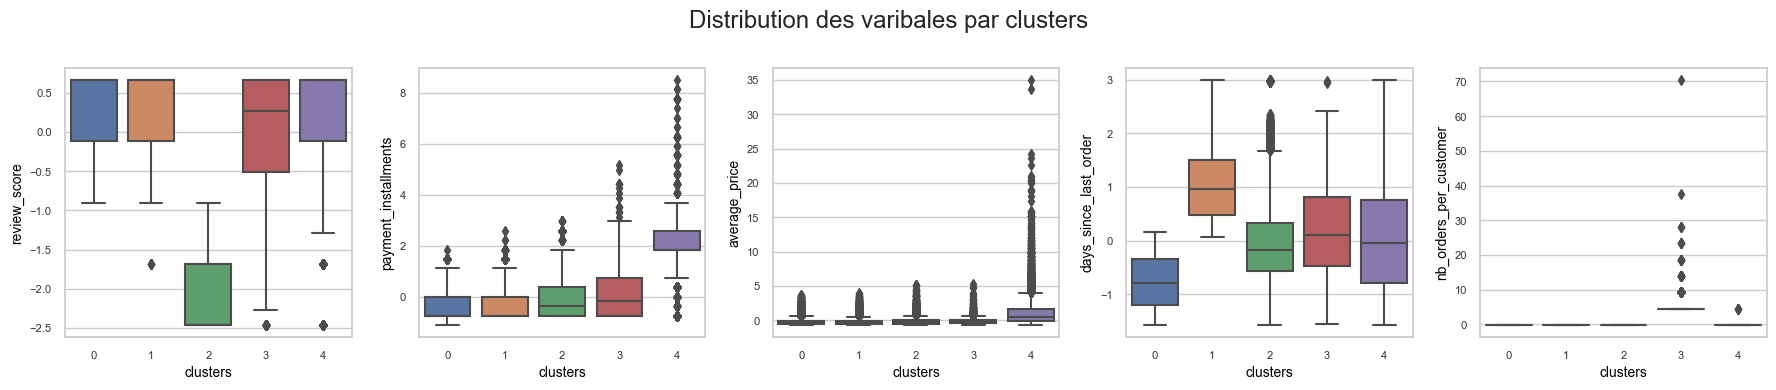

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
plt.suptitle("Distribution des varibales par clusters")

for ax, column in zip(axs.flatten(), df_kmean.drop(columns="clusters").columns):
    sns.boxplot(x='clusters', y=column, data=df_kmean, ax=ax)
    

plt.tight_layout()
plt.show()

Test

#### **4.2   CAH - Classification Ascendante Hiérarchique**

In [31]:
# Instanciation du nombre de clusters
n_clust = 10000
# Instanciation du clustering k-means
km = KMeans(n_clusters=n_clust, n_init="auto", random_state=42)
# Application du K-means sur le data set
km.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

In [32]:
# Instanciation du df suite clustering
df_kmean = pd.DataFrame(X, columns=df_cluster.columns)
# Ajout de la colonne clusters + Remplissage avec le n° cluster correspondant
df_kmean['clusters'] = clusters

In [33]:
# Moyenne des composantes par clusters
centroide_kmean = df_kmean.groupby(by='clusters').mean()

In [35]:
# Transformation - Centrage-Réduction / Mise à l'échelle (moyenne=0; Ecart-type=1)
X = sc.fit_transform(centroide_kmean)

In [45]:
#Préparation des données pour le clustering
names = centroide_kmean.index.values

In [36]:
#Clustering hiérarchique
Z = linkage(X, 'ward')

In [38]:
#Mesure de similarité intercluster - Mesure de qualité d'une partition d'un ensemble de données
score = []

for n_clust in range(2,10):
  #Clustering par classification hiérarchique
  clusters = fcluster(Z, n_clust, criterion='maxclust')
  #Application de la mesure Davies Bouldin
  score.append(davies_bouldin_score(X, clusters))

print(score)

[1.4259423633043924, 1.564207077900942, 1.5220868064091668, 1.3411784864224336, 1.2577887735178452, 1.2386746921626037, 1.234267300107229, 1.2630090386824493]


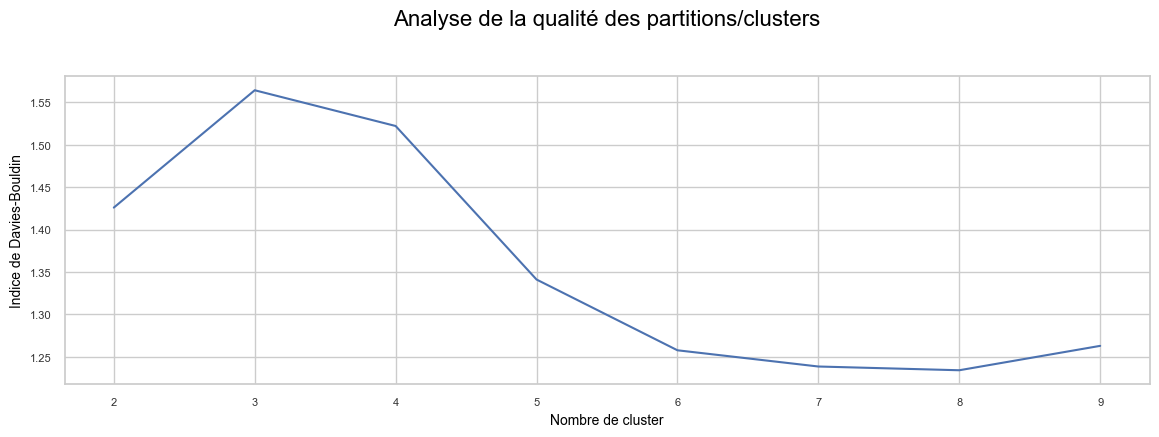

In [55]:
#Analyse des regroupements de clusters
plt.figure(figsize=(14,4))
plt.plot(range(2,10), score)
plt.title('Analyse de la qualité des partitions/clusters\n')
plt.xlabel("Nombre de cluster")
plt.ylabel("Indice de Davies-Bouldin")
plt.show()

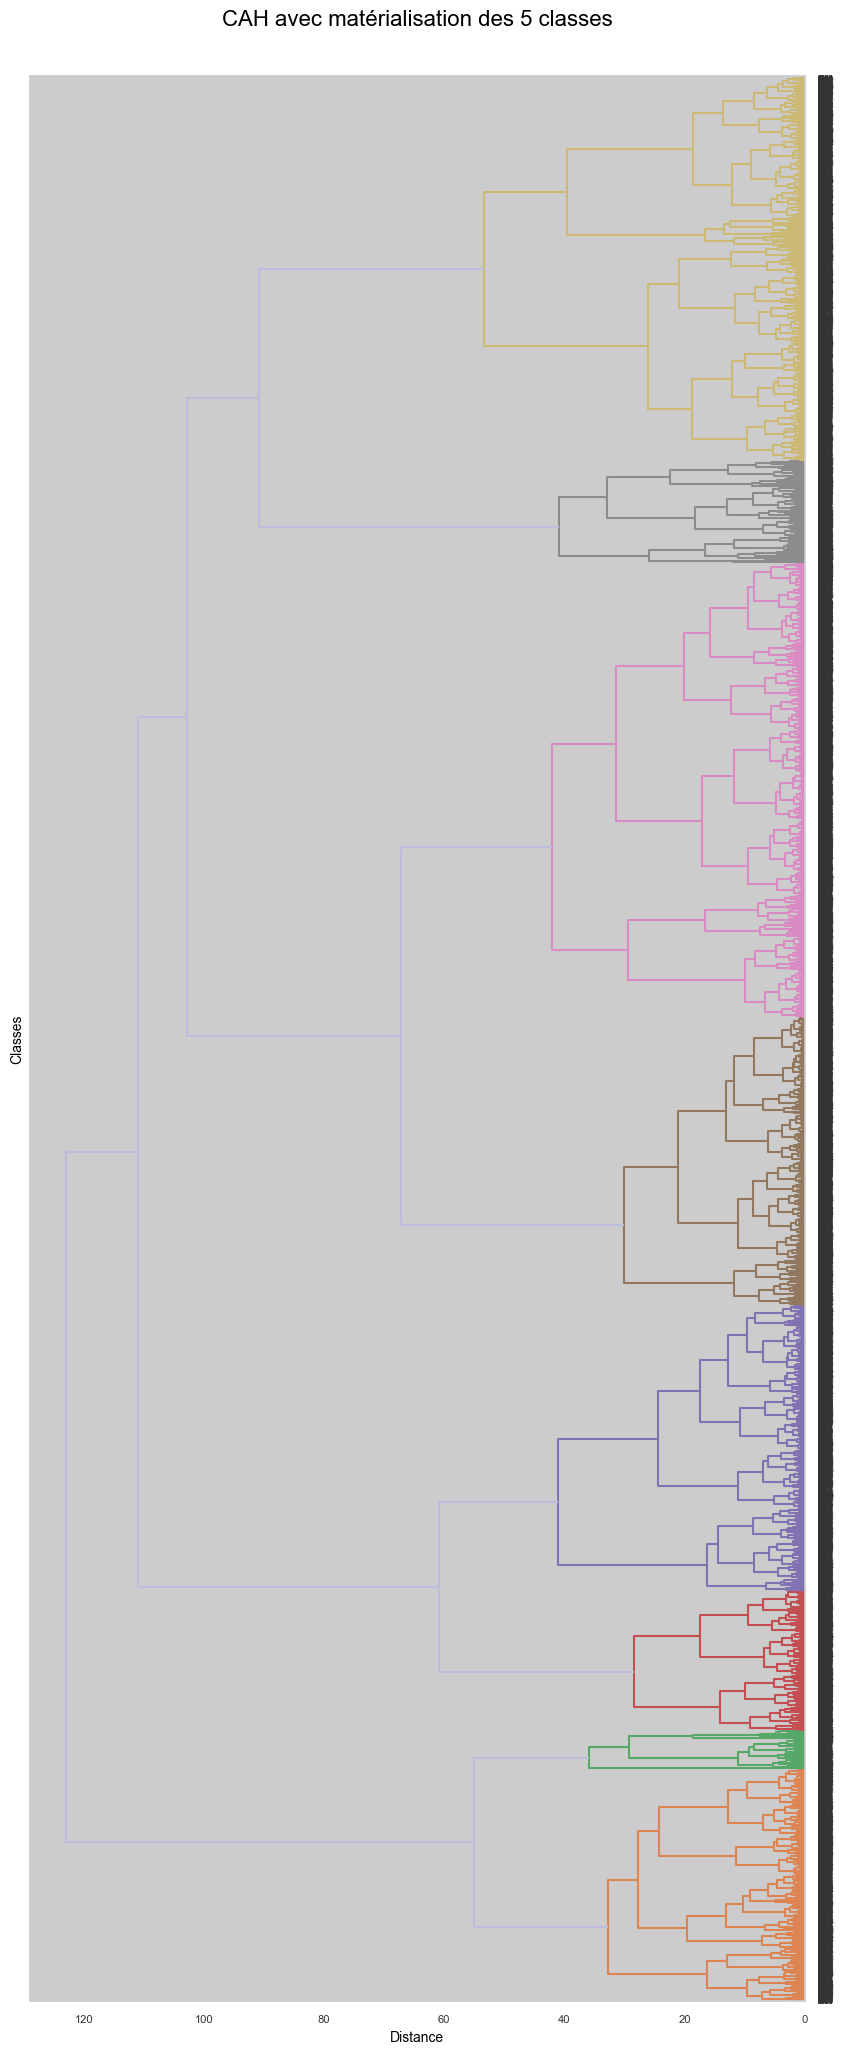

In [60]:
#Affichage du dendrogramme
plt.figure(figsize=(10,25))
dendrogram(Z,labels=names,orientation='left',color_threshold=54, above_threshold_color='#bcbddc')
plt.title('CAH avec matérialisation des 5 classes\n')
plt.xlabel('Distance')
plt.ylabel('Classes')
plt.show()

In [61]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 8, criterion='maxclust')
#Instanciation du df
df_cah = pd.DataFrame(X, columns=centroide_kmean.columns)
#Ajout de la colonne clusters + Remplissage avec le n cluster correspondant
df_cah['clusters'] = clusters
#print(df_cah)

In [63]:
#Moyenne des composantes par clusters
centroids = df_cah.groupby(by='clusters').mean()

c:\Users\remid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

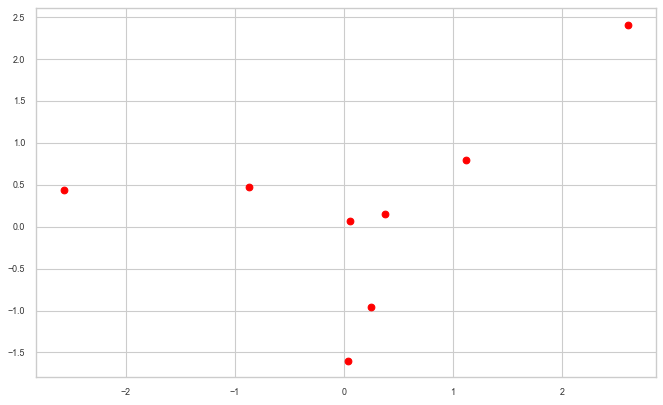

In [66]:
#Observation du 1er plan factoriel avec représentation des individus par clusters
plt.figure(figsize=(10,6), dpi=80)
pca = decomposition.PCA(n_components=3).fit(X)
X_projected = pca.transform(X)
#centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1], label='Centroide', c='red')
plt.scatter(X_projected[:,0], X_projected[:,1], c=clusters.astype(np.float), alpha=.8, cmap = (mpl.colors.ListedColormap(['pink', 'green', 'blue', 'cyan', 'black', 'brown'])))
plt.colorbar()
plt.title("Projection des {} centres sur le 1e plan factoriel\n".format(len(centroids)), fontsize=18, color='#AA2D21')
plt.xticks(color='#36281B')
plt.yticks(color='#36281B')
plt.legend()
plt.show()

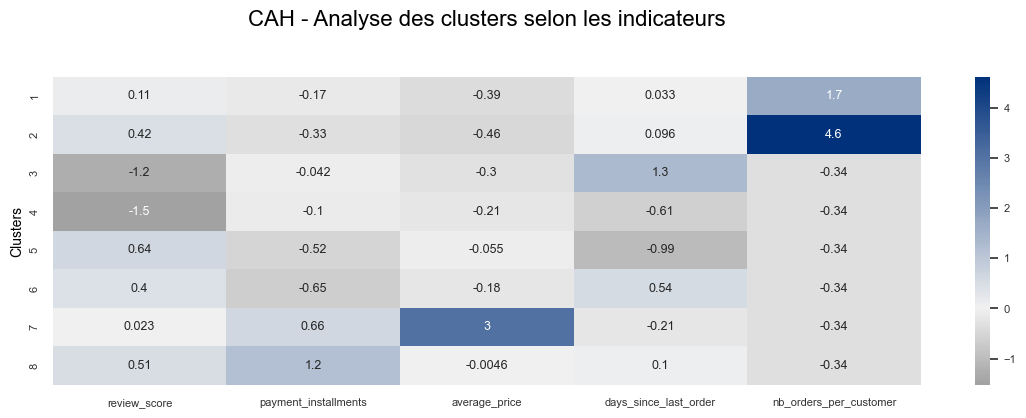

In [71]:
#Création du heatmap pour observer les différents clusters et composantes
plt.figure(figsize=(14,4))
sns.heatmap(centroids, center=0, cmap=heatmap_color, annot=True, annot_kws={'size': 9})
plt.title('CAH - Analyse des clusters selon les indicateurs\n')
plt.ylabel('Clusters')
plt.show()

#### **4.3   DBSCAN**

tester avec min_samples=100 et surtout faire une boucle pour teser plusieurs paramètre (type daviesbouldin).

In [ ]:
data_scaled = sc.fit_transform(df)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data_scaled)
df['cluster'] = dbscan.labels_

In [ ]:
df["cluster"].value_counts()

analyse temporelle - prendre une date initiale
Kmeans.fit (kmeans0)
Ajouter une semaine ()
kmeans0.predict()

Kmeans1.fit()
predict()

Comparer les résultats avec ARI

Ajouter une semaine et recommancer pour comparer 2 dates


### **2. orders_data**

---


* OK - Ajouter recense (mesurer depuis quand le client n'a pas commander)
* OK - RFM (Recense/Frequence d'achat/Monnaie Value)
* OK - ACP (Observer l'ensemble des plans)
* Kmeans (description métier des cluster, boxplot, scatter), cluster 1 client qui dépensent beaucoup, cluster 2 les petits achetrys. 
* CAH
* DBSCAN


Appliquer powertransformer ou quantiletransformer 

Utiliser silouhette et comparer avec davies bouldin

